In [1]:
## Loading of sqlite tables to pandas DataFrames
import sqlite3
import pandas as pd

conn = sqlite3.connect(r'/kaggle/input/data-bank-data-with-danny/data_bank.db')
regions = pd.read_sql_query("SELECT * FROM regions;", conn)
customer_nodes = pd.read_sql_query("SELECT * FROM customer_nodes;", conn)
customer_transactions = pd.read_sql_query("SELECT * FROM customer_transactions;", conn)

You will be using the dataset [Data Bank](https://8weeksqlchallenge.com/case-study-4/)\*. 
You can find a detailed description of the dataset through the provided link. 

Although the original data is stored in a SQLite database, the tables have been converted to pandas DataFrames.

Please answer the following questions and write a concise summary for a non-technical stakeholder of the results you got.

**Questions**
 1. What is the unique count and total amount for each transaction type?
 2. What is the average total historical deposit counts and amounts for all customers?
 3. For each month - how many Data Bank customers make more than 1 deposit and either 1 purchase or 1 withdrawal in a single month?
 4. What is the closing balance for each customer at the end of the month?
 5. What is the percentage of customers who increase their closing balance by more than 5%?
 6. Who are the clients most likely to churn? Provide a detailed explanation of your reasoning.

From cell *Start your report here* feel free to structure the report in the manner you find most effective. This task should not take you longer than 2 hours.

\* *Data sourced by Danny Ma and the Data With Danny virtual data apprenticeship program in their 8 Week SQL Challenge*

**Start your report here**

## Customer Transaction Analysis - Data Bank

### Executive Summary

The Data Bank team provided a data model containing transaction details of 500 customers spread over the world, covering the period from January 2020 to April 2020.

Our analysis shows that deposits constitute the majority and highest value of transactions, with the average customer making 5 deposits totaling €2501 over the four-month period.

In contrast, customers are less active when it comes to purchases and withdrawals. Each month, we found that more than half of the customers did not make at least one deposit and one purchase or withdrawal. Perhaps a Marketing campaign is in order.

Overall, 26% of the customers increased their closing balance by 5% or more between January and April. However, 35% experience a decrease during the same period.

By focusing on deposit transactions, which are less likely to represent intention of churn than withdrawasl and purchases, we identified 21 customers at extreme risk of churning. 
Among these, we recommend prioritizing the retention of clients 58 and 127; for the rest, we advise a demographic analysis, since while their transactions at the moment have low value, they might become high-valued clients in the future - such is often the case with college students.

### General data preparation

In [2]:
customer_transactions['txn_date'] = pd.to_datetime(customer_transactions['txn_date'])
customer_transactions['year_month'] = customer_transactions['txn_date'].dt.to_period('M').astype(str)

### Questions

#### Question 1 - What is the unique count and total amount for each transaction type?

In [3]:
customer_transactions_without_duplicates: pd.DataFrame = customer_transactions.drop_duplicates()

customer_transactions_without_duplicates.groupby('txn_type').agg(
    unique_count=('txn_type', 'count'),
    total_amount=('txn_amount', 'sum')
)

,unique_count,total_amount
txn_type,,
deposit,2671,1359168
purchase,1617,806537
withdrawal,1580,793003


#### Question 2 - What is the average total historical deposit counts and amounts for all customers?

Since average can be either mean or median, let's use median since it is more robust against outliers. 

Plus, it allows us to make statements like the "The average customer makes x transactions in a total of y".

In [4]:
deposit_transactions = customer_transactions[customer_transactions['txn_type'] == 'deposit']

tmp_historical_data: pd.Series = deposit_transactions.groupby('customer_id').agg({'txn_amount': ['count', 'sum']}).median()

print(f"Average amount: {tmp_historical_data.loc[('txn_amount', 'sum')]:.2f}€")
print(f"Average counts: {tmp_historical_data.loc[('txn_amount', 'count')]:.0f}")

Average amount: 2501.00€
Average counts: 5


#### Question 3 - For each month - how many Data Bank customers make more than 1 deposit and either 1 purchase or 1 withdrawal in a single month?

In [5]:
non_deposit_transactions = customer_transactions[customer_transactions['txn_type'] != 'deposit']
customers_with_more_than1_deposit = deposit_transactions[['customer_id', 
                                                          'year_month']].value_counts().loc[lambda x: x>1].reset_index()
pd.merge(customers_with_more_than1_deposit, non_deposit_transactions, 
         on=['customer_id', 'year_month'],
         how = 'inner'
        ).groupby('year_month')['customer_id'].nunique()

year_month
2020-01    168
2020-02    181
2020-03    192
2020-04     70
Name: customer_id, dtype: int64

#### Question 4 - What is the closing balance for each customer at the end of the month?

Will assume it is at the end of each month

In [6]:
closing_balances_df: pd.DataFrame = pd.merge(
    deposit_transactions.groupby(['customer_id', 'year_month'])['txn_amount'].sum().reset_index(),
    non_deposit_transactions.groupby(['customer_id', 'year_month'])['txn_amount'].sum().reset_index(),
    how = 'outer',
    on = ['customer_id', 'year_month']
).fillna(0)

closing_balances_df = closing_balances_df.assign(monthly_balance = closing_balances_df['txn_amount_x'] - 
                                                 closing_balances_df['txn_amount_y'])

closing_balances_df["closing_balance"] = closing_balances_df.sort_values([
    "customer_id", "year_month"]).groupby("customer_id")["monthly_balance"].cumsum()

closing_balances_df[["customer_id", "year_month", "closing_balance"]]

,customer_id,year_month,closing_balance
0,1,2020-01,312.0
1,1,2020-03,-640.0
2,2,2020-01,549.0
3,2,2020-03,610.0
4,3,2020-01,144.0
...,...,...,...
1715,499,2020-02,1415.0
1716,499,2020-03,599.0
1717,500,2020-01,1594.0
1718,500,2020-02,2981.0


Distribution of closing balances


<Axes: >

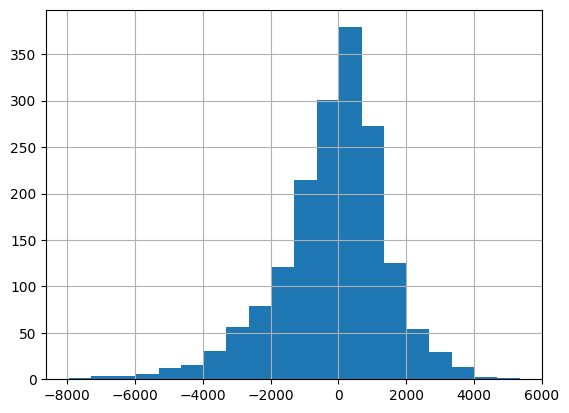

In [7]:
print(f"Distribution of closing balances")
closing_balances_df['closing_balance'].hist(bins=20)

Is more or less uniform.

#### Question 5 - What is the percentage of customers who increase their closing balance by more than 5%?

Will assume it is the percentage of customers who were with data bank on 2020-01 that increased their closing balance by more than 5% by 2020-04.

In [8]:
closing_balances_change: pd.DataFrame = closing_balances_df[closing_balances_df
                                             ['year_month'].isin(['2020-01', 
                                                                  '2020-04'])].sort_values(['customer_id', 'year_month'])
                                            
closing_balances_change = closing_balances_change.assign(
    balance_pct_change = closing_balances_change.groupby('customer_id')['closing_balance'].pct_change()
)

def get_perc_of_customers_per_pct_change(closing_balances_change: pd.DataFrame,
                                           value_limits: tuple[float] = (0.05, 1000),
                                           balance_pct_change_col: str = 'balance_pct_change',
                                           customer_id_col: str = 'customer_id'
                                          ) -> int:

        return closing_balances_change[(closing_balances_change[balance_pct_change_col] >= value_limits[0]) & (
        closing_balances_change[balance_pct_change_col] <= value_limits[1])][customer_id_col].nunique()/(
        closing_balances_change[customer_id_col].nunique())

print(
f"Percentage of customers who increased their closing balance \
by more than 5% between 2020-01 and 2020-04: {get_perc_of_customers_per_pct_change(closing_balances_change):.2%}"
)

print(
f"Percentage of customers who decreased their closing balance \
by more than 5% between 2020-01 and 2020-04: {get_perc_of_customers_per_pct_change(closing_balances_change, value_limits=(-1000, 0)):.2%}"
)


Percentage of customers who increased their closing balance by more than 5% between 2020-01 and 2020-04: 26.20%
Percentage of customers who decreased their closing balance by more than 5% between 2020-01 and 2020-04: 35.40%


#### Question 6 - Who are the clients most likely to churn?

I will focus just on deposit transactions since withdrawals and purchases can either represent normal behavior or intention to churn.

We could assume that customers with no deposits have churned, so that we had a labeled dataset, and employ a supervised classification technique but (1) that is not true since there are more unique customers in 2020-03 than on 2020-04 and (2) that takes more time and effort than requested. An RFM analysis will do just as fine.

Still, I will focus only on customers who did deposits after 2020-03, because the rest might already have churned.

Because we are just looking at customers at risk, will look at recency and frequency mostly, and use monetary to evaluate their current worth. However, be aware that clients with current worth low may end up as high earners; this is often the case of college students.

In [9]:
today: pd.Timestamp = pd.to_datetime('2020-05-01')

rfm_table: pd.DataFrame = deposit_transactions[deposit_transactions['txn_date'] >= '2020-04-01'].groupby(
    'customer_id').agg({
    'txn_date': lambda x: (today - x.max()).days,
    'customer_id': 'count',
    'txn_amount': 'sum'
}).rename(columns={'txn_date': 'Recency', 'customer_id': 'Frequency', 'txn_amount': 'Monetary'})

In [10]:
def calculate_rfm_score (rfm_table: pd.DataFrame, r_labels: range, fm_labels: range):
    rfm_table = rfm_table.assign(
        R = pd.qcut(x= rfm_table["Recency"], q=len(r_labels), labels=r_labels, duplicates='drop').astype(int),
        F = pd.qcut(x= rfm_table["Frequency"], q=len(fm_labels), labels=False, duplicates='drop').astype(int),
        M = pd.qcut(x= rfm_table["Monetary"], q=len(fm_labels), labels=False, duplicates='drop').astype(int)
    )    
    
    rfm_table = rfm_table.assign(
        RFM_score = rfm_table['R'] + rfm_table['F'] + rfm_table['M'],
        RFM_segment = rfm_table['R'].astype(str) + rfm_table['F'].astype(str) + rfm_table['M'].astype(str)
    )
    return rfm_table

rfm_table = calculate_rfm_score (rfm_table, range(8, -1, -1), range(0, 9, 1)) # odd number of labels

In [11]:
rfm_table['RF_score'] = rfm_table['R'] + rfm_table['F']
rfm_table.sort_values('RF_score')
most_likely_to_churn: pd.DataFrame = rfm_table[(rfm_table['RF_score']<=0)].sort_values(by="M", ascending=False)

print(f"Better than average clients at very high risk of churn: {list(most_likely_to_churn.loc[most_likely_to_churn['M'] > 5].index)}")
print(f"Average clients at very high risk of churn: {list(most_likely_to_churn.loc[most_likely_to_churn['M'] == 5].index)}")
print(f"Worse than average clients at very high risk of churn: {list(most_likely_to_churn.loc[most_likely_to_churn['M'] < 5].index)}")

Better than average clients at very high risk of churn: [58, 127]
Average clients at very high risk of churn: [460, 271, 340]
Worse than average clients at very high risk of churn: [15, 389, 272, 390, 387, 142, 308, 67, 418, 437, 311, 363, 358, 56, 136, 488]


In [12]:
### Additional questions
print(f"Number of clients: {customer_nodes['customer_id'].nunique()}")
print(f"Number of clients at extreme risk: {len(most_likely_to_churn)}")

Number of clients: 500
Number of clients at extreme risk: 21


In [14]:
rfm_table.to_csv("rfm_table.csv")